In [1]:
import pandas as pd
import numpy as np
from graspologic.embed import ClassicalMDS
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import RBFInterpolator, LinearNDInterpolator

from tqdm import tqdm

%matplotlib inline

DATAFILE_PATH='/mnt/c/Users/hhelm/Documents/Helivan/Software/medqa_pain_top_10.csv'

/mnt/c/Users/hhelm/Documents/Helivan/Software/venvs/pnma/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/c/Users/hhelm/Documents/Helivan/Software/venvs/pnma/lib/python3.8/site-packages/graspologic/models/edge_swaps.py:215: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  _edge_swap_numba = nb.jit(_edge_swap, nopython=False)


In [2]:
medical_qas = pd.read_csv(DATAFILE_PATH)
question_list = list(medical_qas['question'])
answer_idx_list = list(medical_qas['answer_idx'])
options_list = list(medical_qas['options'])

medical_qas.head(1)

,Unnamed: 0,question,answer,options,meta_info,answer_idx,metamap_phrases,mentions_pain,race,prompt,intervened_prompt_race=African American,intervened_prompt_race=Caucasian,model_responses_race=African American,model_responses_race=Caucasian,model_answers_race=African American,model_answers_race=Caucasian,model_answers_diff
0,25,A 53-year-old man comes to the emergency depar...,Urinary pH: 4.7,"{'A': 'Urinary pH: 7.3', 'B': 'Urinary pH: 4.7...",step2&3,B,"['year old man', 'emergency department', 'of s...",True,The text does not provide information about th...,A 53-year-old man comes to the emergency depar...,An African American 53-year-old man comes to t...,A 53-year-old Caucasian man comes to the emerg...,"[""The patient's symptoms (severe colicky pain ...","[""This patient's severe, colicky, right-sided ...","['B', 'B', 'B', 'B', 'B']","['B', 'A', 'B', 'A', 'A']",6


In [3]:
import pickle

embeddings_and_probs = pickle.load(open('/mnt/c/Users/hhelm/Documents/Helivan/Microsoft/data/embeddings_and_probs_medqa_10.p', 'rb'))
embeddings_dict = embeddings_and_probs['embeddings']
probs_dict = embeddings_and_probs['probs']

dict_key = 'interventions'
intervention_list = list(embeddings_dict[dict_key].keys())

embeddings_no_change = embeddings_dict['perturbations'][0]
probs_no_change = probs_dict['perturbations'][0]

In [4]:
base_embeddings = []
for k in embeddings_no_change.keys():
    base_embeddings += list(embeddings_no_change[k][0])
base_embeddings = np.array(base_embeddings)
base_cmds = ClassicalMDS(n_components=2).fit_transform(base_embeddings)

Text(0.5, 1.0, 'CMDS representations of original questions')

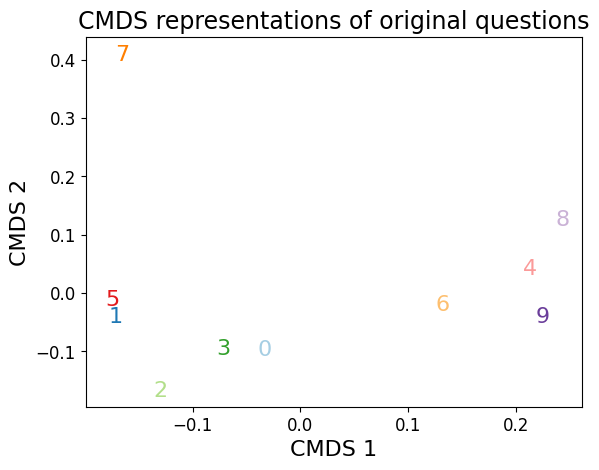

In [5]:
import seaborn as sns

fig, ax = plt.subplots(1,1)

colors=sns.color_palette("Paired", n_colors=10)

for i in range(10):
    ax.text(base_cmds[i, 0], base_cmds[i, 1], s=i, fontsize=16, c=colors[i])
    
miny = np.min(base_cmds[:, 1])
maxy = np.max(base_cmds[:, 1])

minx = np.min(base_cmds[:, 0])
maxx = np.max(base_cmds[:, 0])

ax.set_xlim(minx - 0.1*abs(minx), maxx + 0.1*abs(maxx))
ax.set_ylim(miny - 0.1*abs(miny), maxy + 0.1*abs(maxy))

ax.set_xlabel('CMDS 1', fontsize=16)
ax.set_ylabel('CMDS 2', fontsize=16)
ax.tick_params(labelsize=12)

ax.set_title('CMDS representations of original questions', fontsize=17)

In [6]:
from scipy.spatial import procrustes

question_list = list(embeddings_dict[dict_key][intervention_list[0]].keys())
n_perturbations = len(embeddings_dict[dict_key][intervention_list[0]][question_list[0]])
intervention_list = list(embeddings_dict[dict_key].keys())

print(f'n questions: {len(question_list)}, n perturbations: {n_perturbations}, intervention list: {intervention_list}')

n questions: 10, n perturbations: 26, intervention list: ['Caucasian', 'White', 'of European descent', 'Western']


Text(0.5, 1.0, 'Demographic fuzzing: "White"')

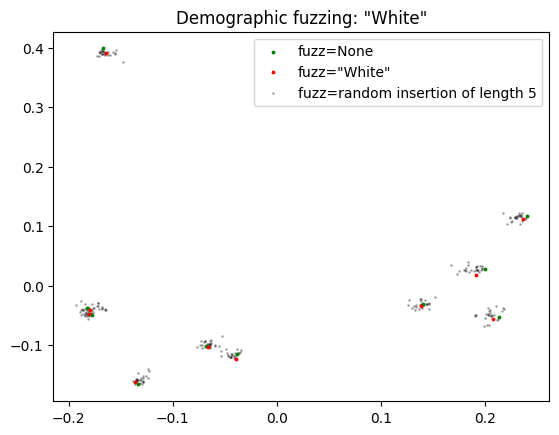

In [7]:
intervention= 'White'

temp_embeddings = []
for question in question_list:
    temp_embeddings.append(embeddings_no_change[question][0])
    for key in embeddings_dict[dict_key][intervention][question]:
        temp_embeddings.append(embeddings_dict[dict_key][intervention][question][key])
        
temp_embeddings=np.array(temp_embeddings)
temp_cmds = ClassicalMDS(n_components=2).fit_transform(temp_embeddings)

m = len(embeddings_dict[dict_key][intervention][question]) + 1

fig, ax = plt.subplots(1,1)

for i in range(len(question_list)):
    begin = i*m
    end = (i+1)*m
    
    if i == 0:
        label_0 = 'fuzz=None'
        label_1 = f'fuzz="{intervention}"'
        label_2 = f'fuzz=random insertion of length {len(intervention)}'
    else:
        label_0=None
        label_1=None
        label_2=None
        
        
    ax.scatter(temp_cmds[begin+2:end, 0], temp_cmds[begin+2:end, 1], c='k', alpha=0.25, s=1, label=label_2)
    ax.scatter(temp_cmds[begin, 0], temp_cmds[begin, 1], c='g', alpha=1,s=3, label=label_0)
    ax.scatter(temp_cmds[begin+1, 0], temp_cmds[begin+1, 1], c='r', alpha=1,s=3, label=label_1)
    
ax.legend(*(
    [x[i] for i in [1,2,0] ]
    for x in plt.gca().get_legend_handles_labels()
))

ax.set_title(f'Demographic fuzzing: "{intervention}"')

Text(0.5, 1.05, 'Fuzzing="White"')

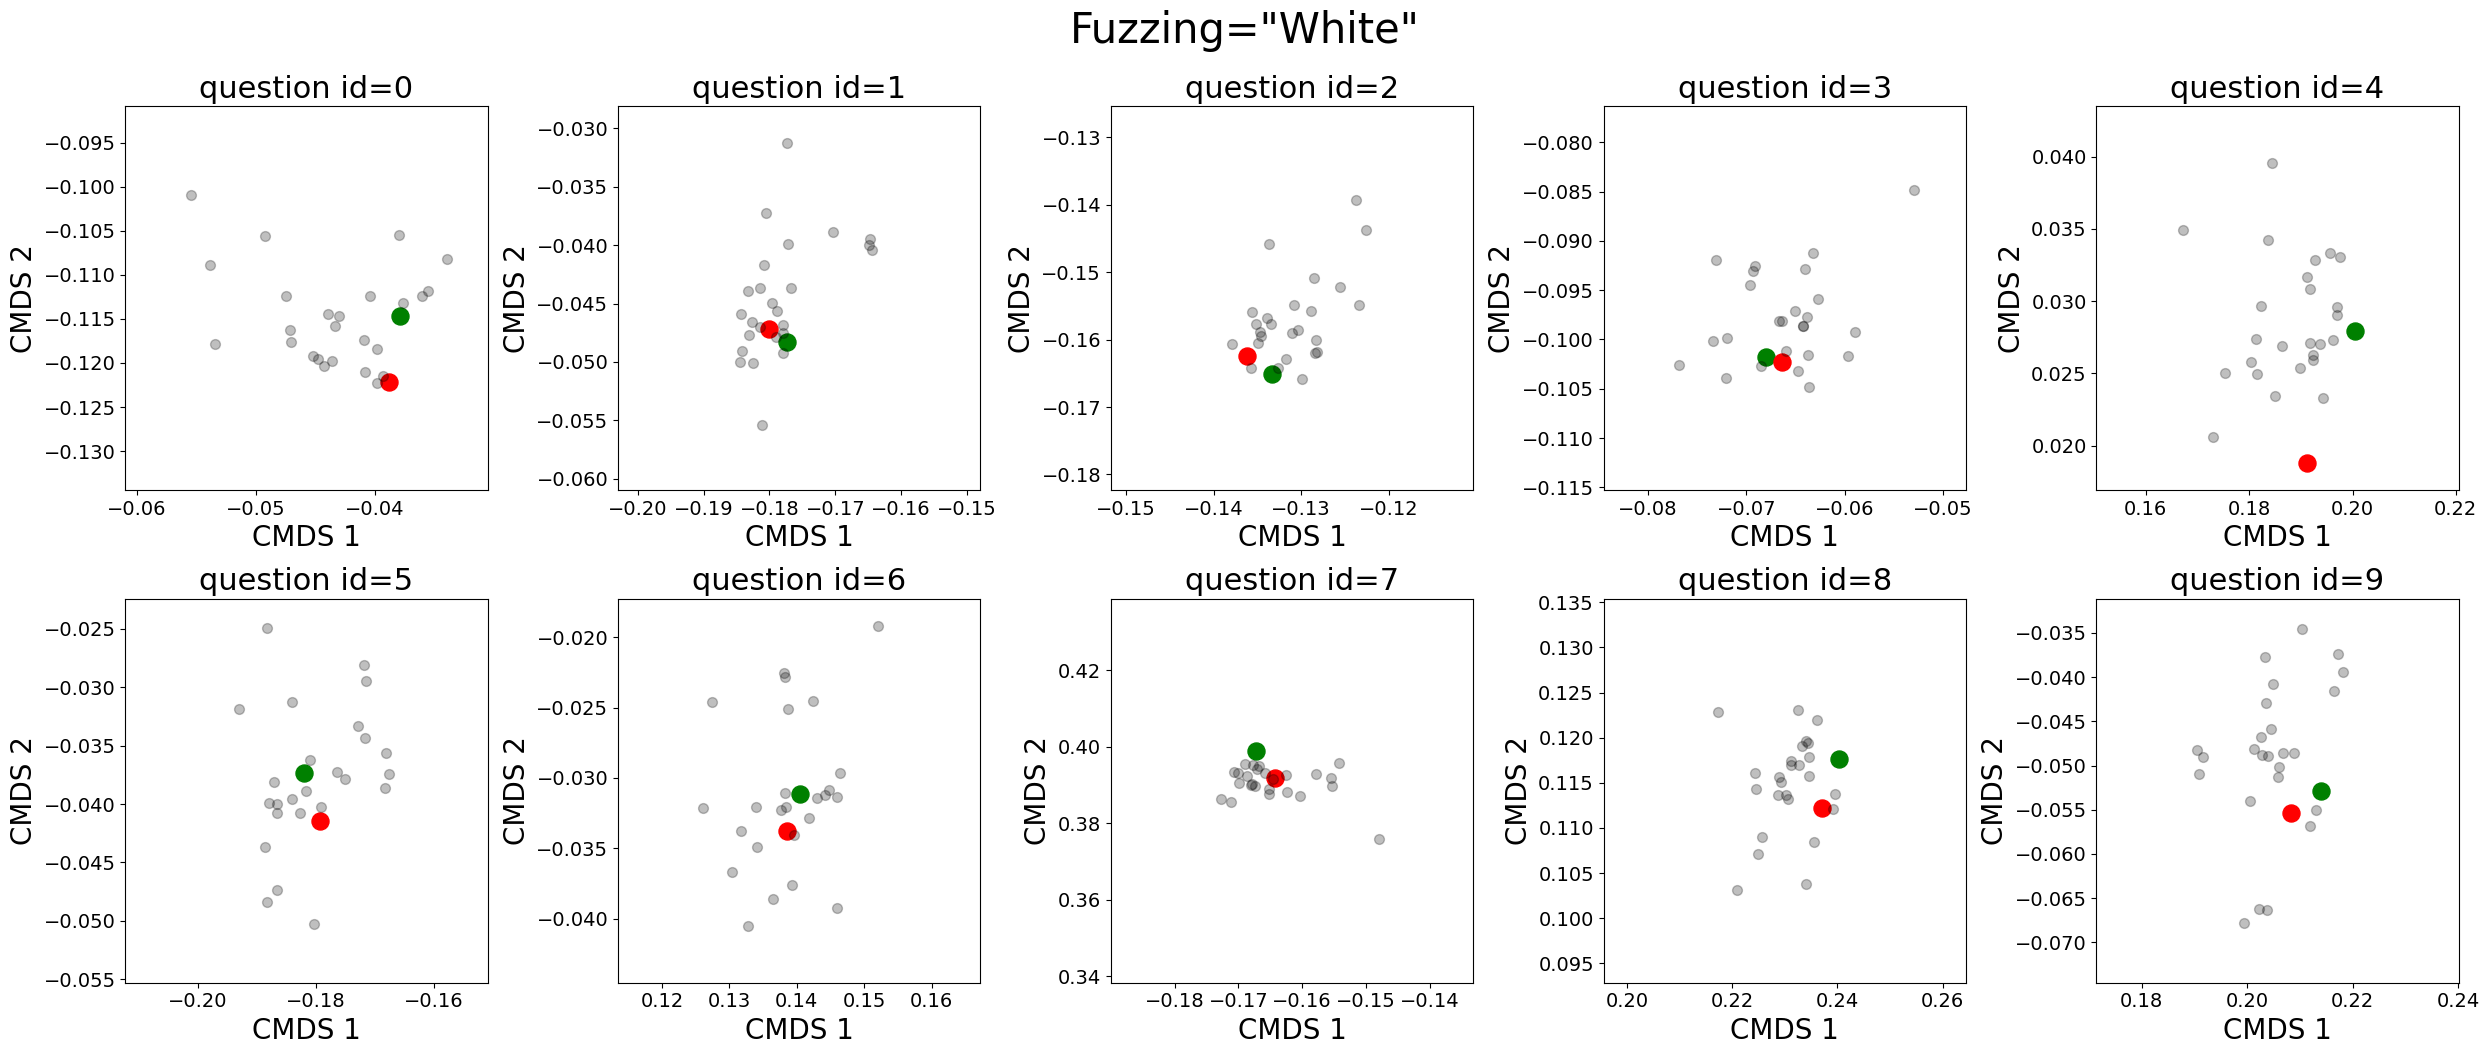

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))

for i, question in enumerate(question_list):
    col = i % 5
    row = int(np.math.floor(i/5))
    
    start = i * m
    end = (i+1) * m
    inds = np.arange(start, end)
                        
    for ind in inds:
        if ind == start:
            ax[row, col].scatter(temp_cmds[ind, 0], temp_cmds[ind, 1], s=150, alpha=1, c='g')
        elif ind == start+1:
            ax[row, col].scatter(temp_cmds[ind, 0], temp_cmds[ind, 1], s=150, alpha=1,  c='r')
        else:
            ax[row, col].scatter(temp_cmds[ind, 0], temp_cmds[ind, 1], s=50, alpha=0.25, c='k')
            
    miny = np.min(temp_cmds[inds, 1])
    maxy = np.max(temp_cmds[inds, 1])
    
    minx = np.min(temp_cmds[inds, 0])
    maxx = np.max(temp_cmds[inds, 0])
    
    ax[row, col].set_xlim(minx - 0.1*abs(minx), maxx + 0.1*abs(maxx))
    ax[row, col].set_ylim(miny - 0.1*abs(miny), maxy + 0.1*abs(maxy))
                
    ax[row, col].set_xlabel('CMDS 1', fontsize=20)
    ax[row, col].set_ylabel('CMDS 2', fontsize=20)
    
    ax[row, col].tick_params(labelsize=14)
    
    ax[row, col].set_title(f'question id={i}', fontsize=22)

plt.tight_layout()
fig.suptitle(f'Fuzzing="{intervention}"', fontsize=30, y=1.05)

Text(0.5, 1.05, 'Fuzzing="White"; Fishers meta p-value=1.00')

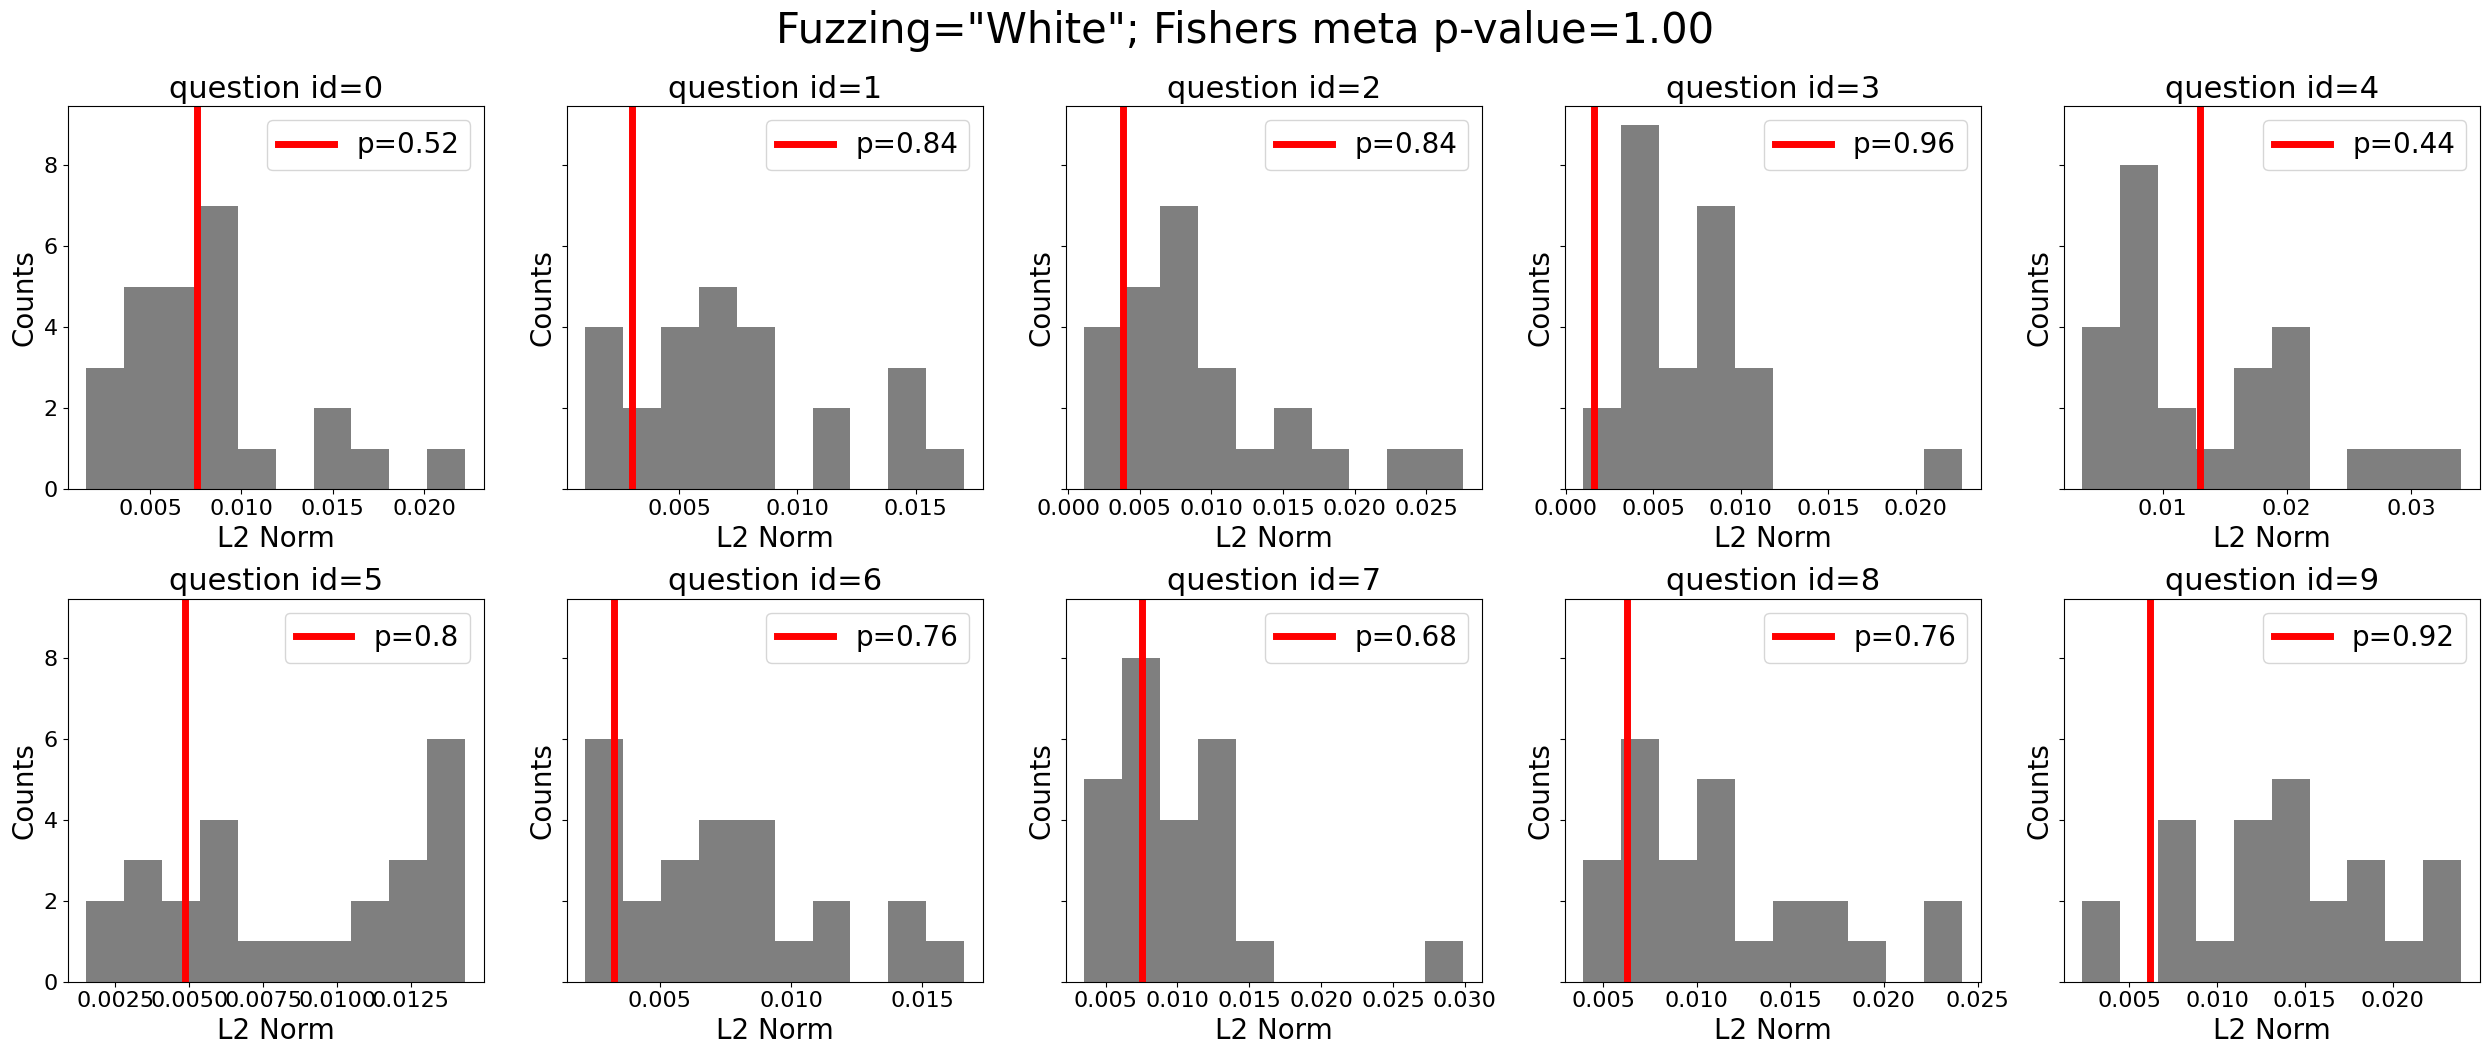

In [9]:
from scipy.stats import combine_pvalues

fig, ax = plt.subplots(2, 5, figsize=(25,10), sharey=True)

embd_distances = {}

p_list=[]
for i, question in enumerate(question_list):
    embd_distances[question] = []
    col = i % 5
    row = int(np.math.floor(i/5))
    
    start=i*m
    end=(i+1)*m
    
    base = temp_cmds[start]
    test = temp_cmds[start+1]
    
    rest = temp_cmds[start+2:end]
    
    rest_dists = np.linalg.norm(base - rest, axis=1)
    test_dist = np.linalg.norm(base - test)
    
    p = max(np.mean(rest_dists >= test_dist), 1/len(rest_dists))
    p_list.append(p)
    
    embd_distances[question] = [test_dist] + list(rest_dists)
    
    ax[row, col].hist(rest_dists, color='k', alpha=0.5)
    ax[row, col].axvline(test_dist, c='r', lw=5, label=f'p={p}')
    
    ax[row, col].set_title(f'question id={i}', fontsize=22)
    ax[row, col].set_ylabel('Counts', fontsize=20)
    ax[row, col].set_xlabel('L2 Norm', fontsize=20)
    
    ax[row, col].tick_params(labelsize=16)
    ax[row, col].legend(fontsize=20)
    
_, meta_p = combine_pvalues(p_list)
plt.tight_layout()
fig.suptitle(f'Fuzzing="{intervention}"; Fishers meta p-value={meta_p:1.2f}', fontsize=30, y=1.05)

Text(0.5, 1.05, 'Fuzzing="White"; Fishers meta p-value=0.50')

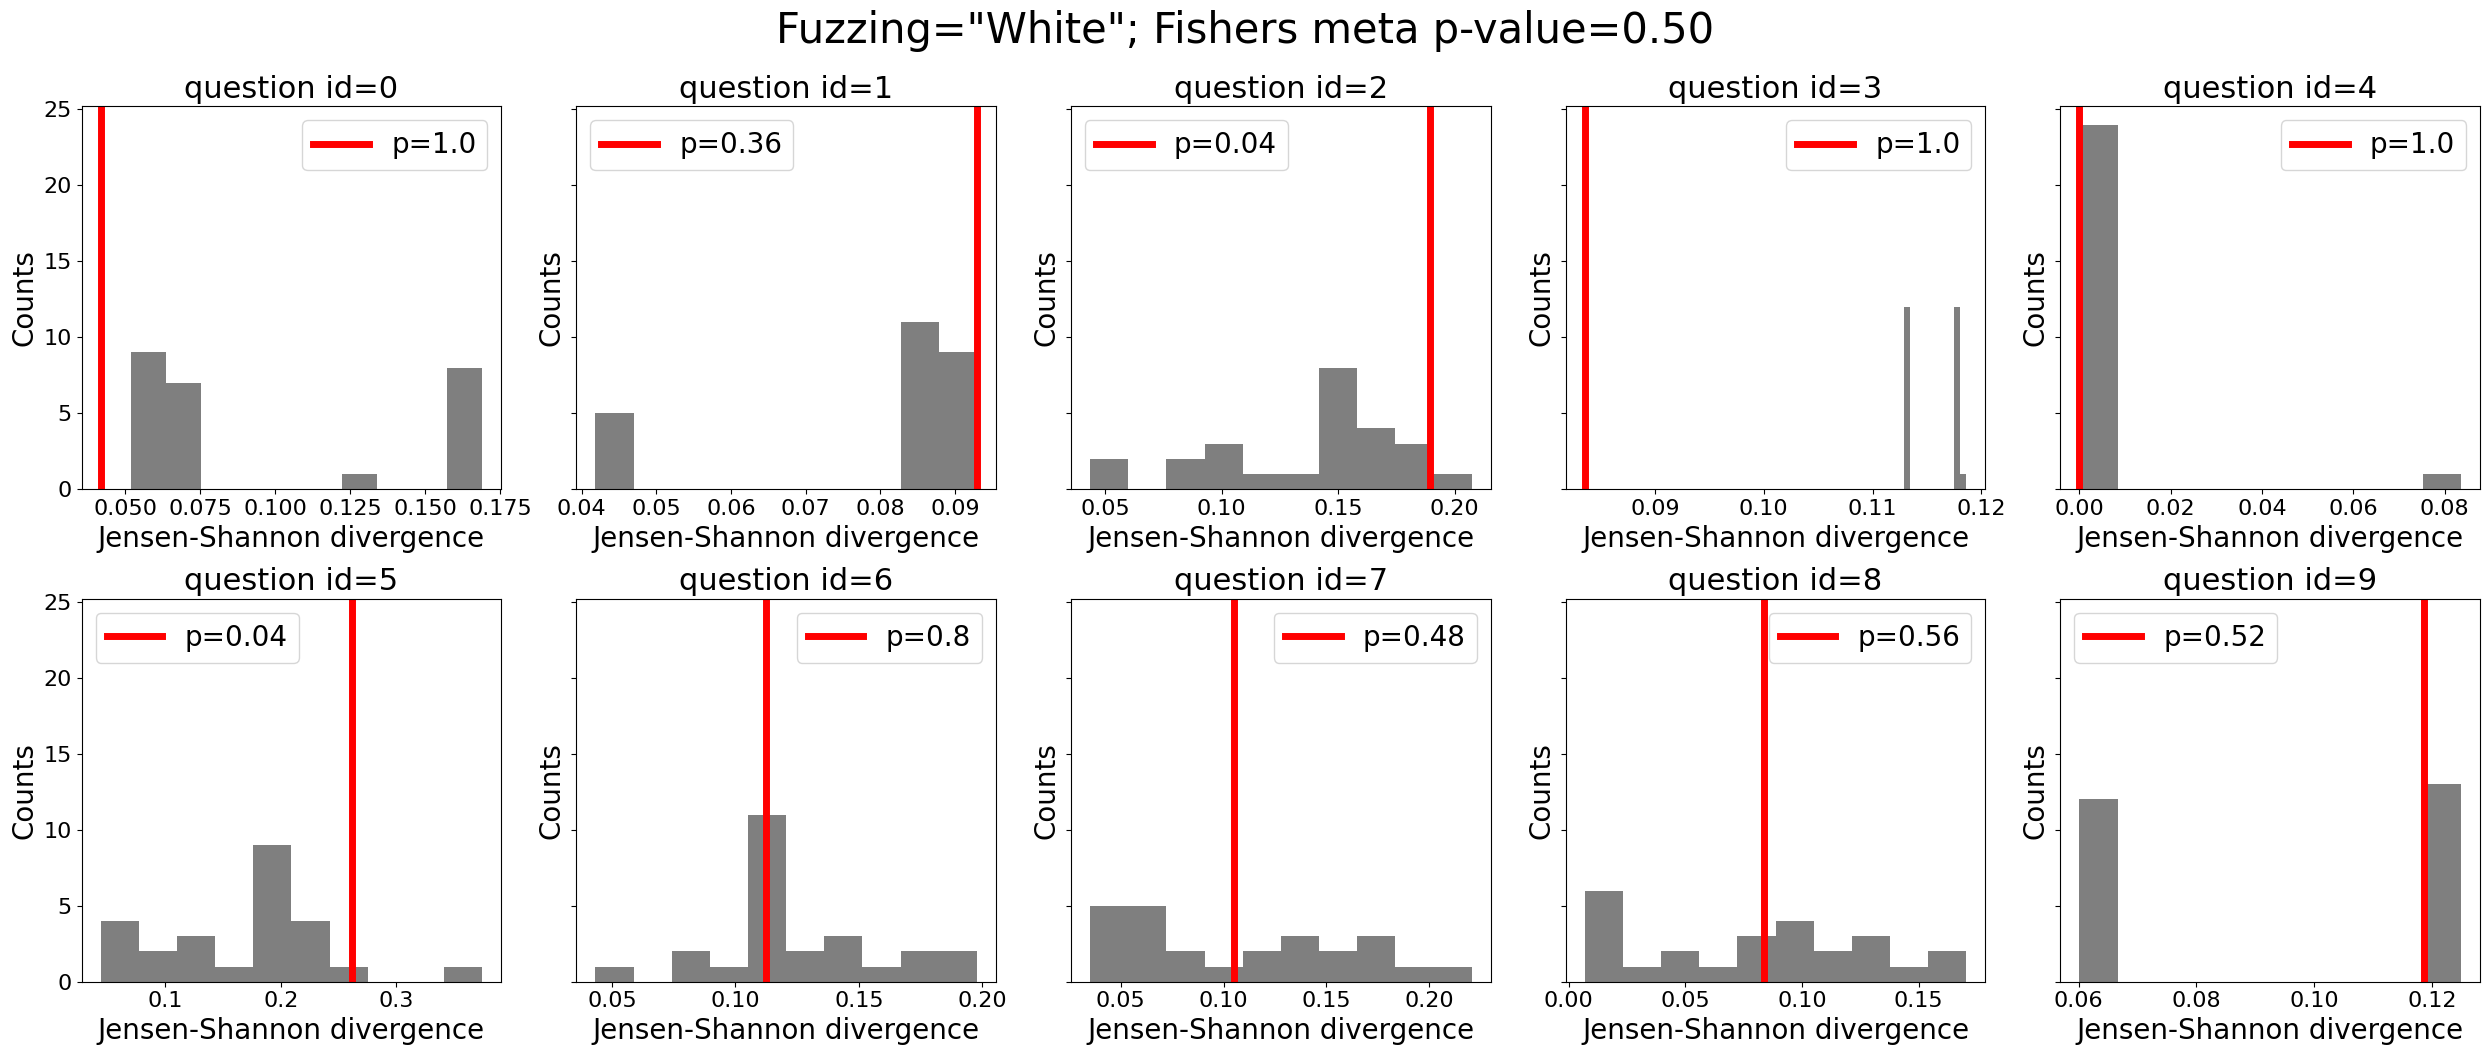

In [10]:
from scipy.spatial.distance import jensenshannon

js_distances = {question: [] for question in question_list}
for question in question_list:
    base_probs = probs_no_change[question][0]
    
    for key in probs_dict[dict_key][intervention][question]:
        
        js_distances[question].append(jensenshannon(base_probs, probs_dict[dict_key][intervention][question][key]))
    
fig, ax = plt.subplots(2, 5, figsize=(25,10), sharey=True)

p_list=[]

for i, question in enumerate(question_list):
    col = i % 5
    row = int(np.math.floor(i/5))
    
    start=i*m
    end=(i+1)*m
    
    temp = js_distances[question]
    
    ax[row, col].hist(temp[1:], color='k', alpha=0.5)
    
    p = max(np.mean(temp[1:] >= temp[0]), 1/len(temp[1:]))

    p_list.append(p)
    ax[row, col].axvline(temp[0], c='r', lw=5, label=f'p={p}')
    
    ax[row, col].set_title(f'question id={i}', fontsize=22)
    ax[row, col].set_ylabel('Counts', fontsize=20)
    ax[row, col].set_xlabel('Jensen-Shannon divergence', fontsize=20)
    
    ax[row, col].tick_params(labelsize=16)
    
    ax[row, col].legend(fontsize=20)
    
_, meta_p = combine_pvalues(p_list)
plt.tight_layout()
fig.suptitle(f'Fuzzing="{intervention}"; Fishers meta p-value={meta_p:1.2f}', fontsize=30, y=1.05)